In [2]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# set up auto load
%load_ext autoreload
%autoreload 2

In [4]:
from load_data import *
from model import *

plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


In [5]:
train_ticker_strings = ["AAPL", "AMZN", "CAT", "GOOG", "HSBC", "KO", "JPM", "PCG", "ABB", "BAC", "BP"]
look_back = 60
train_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

train data size (in batches): 412


In [6]:
train_small_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings[:1], look_back=look_back)
print("train small data size (in batches):", len(train_small_data_loader))

train small data size (in batches): 38


In [7]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 50
lr = 0.01
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)

w_loss = 1
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (multi_head): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=4, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=4, out_features=256, bias=True)
  (relu): ReLU()
 

In [8]:
# try model on small dataset
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_small_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])<=0] = 0
        y_train_bin = y_train.clone()
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device)) 
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()
        
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss, "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

Epoch  10 Total Loss:  2226.400294303894 MSE Loss:  0.0 Binary Loss:  2226.400294303894
Epoch  20 Total Loss:  2221.8584356307983 MSE Loss:  0.0 Binary Loss:  2221.8584356307983
Epoch  30 Total Loss:  2220.7623205184937 MSE Loss:  0.0 Binary Loss:  2220.7623205184937
Epoch  40 Total Loss:  2221.435459136963 MSE Loss:  0.0 Binary Loss:  2221.435459136963


In [9]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 300
lr = 0.001
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)
w_loss = 1
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)


# train the model
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])<=0] = 0
        y_train_bin = y_train.clone()
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device)) 
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()
        
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss, "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

Epoch  10 Total Loss:  24234.9114112854 MSE Loss:  0.0 Binary Loss:  24234.9114112854
Epoch  20 Total Loss:  24232.543966293335 MSE Loss:  0.0 Binary Loss:  24232.543966293335
Epoch  30 Total Loss:  24235.36880683899 MSE Loss:  0.0 Binary Loss:  24235.36880683899
Epoch  40 Total Loss:  24245.28168106079 MSE Loss:  0.0 Binary Loss:  24245.28168106079
Epoch  50 Total Loss:  24237.232927322388 MSE Loss:  0.0 Binary Loss:  24237.232927322388
Epoch  60 Total Loss:  24238.60556793213 MSE Loss:  0.0 Binary Loss:  24238.60556793213
Epoch  70 Total Loss:  24235.20341873169 MSE Loss:  0.0 Binary Loss:  24235.20341873169
Epoch  80 Total Loss:  24225.835968017578 MSE Loss:  0.0 Binary Loss:  24225.835968017578
Epoch  90 Total Loss:  24236.473043441772 MSE Loss:  0.0 Binary Loss:  24236.473043441772
Epoch  100 Total Loss:  24238.673795700073 MSE Loss:  0.0 Binary Loss:  24238.673795700073
Epoch  110 Total Loss:  24232.014240264893 MSE Loss:  0.0 Binary Loss:  24232.014240264893
Epoch  120 Total Los

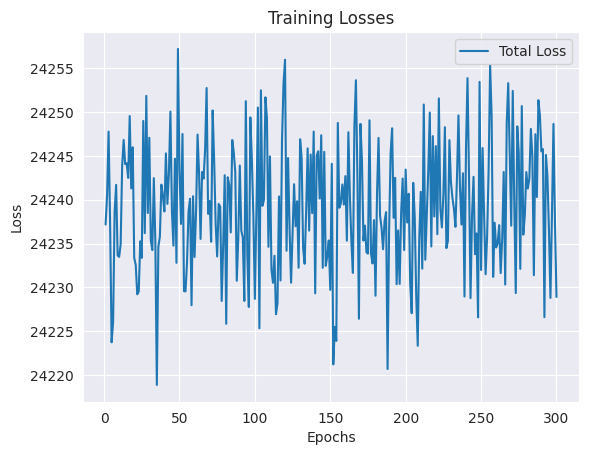

In [10]:
# Plot each line
epochs = range(1, num_epochs+1)
plt.plot(epochs, hist, label='Total Loss')
# plt.plot(epochs, total_mse, label='Total MSE')
# plt.plot(epochs, total_bin, label='Total Bin')

# Add legends, labels, and titles
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

# Display the plot
plt.show()

In [11]:
test_ticker_string = ['MSFT']
test_data_loader = get_data_loader(TransformerMultiFeaturesDataset, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data sze (in batches):", len(test_data_loader))

test data sze (in batches): 38


In [12]:
# make predictions
y_tests = []
y_tests_bin = []
y_test_preds = []
y_test_preds_bin = []
for X_test, y_test in test_data_loader:
    X_test = X_test.to(device)
    y_tests.extend(y_test)
    pred = model(X_test)
    pred = pred.detach().cpu()
    y_test_preds.extend(pred)


# y_tests = test_data_loader.dataset.df['Adj Close'][look_back:].values
y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
testScore_mse = (mean_squared_error(y_tests, y_test_preds))
print('Test Score: %.5f MSE' % (testScore_mse))

y_tests = test_data_loader.dataset.df['Adj Close']
y_tests = np.array(y_tests)
# N, 1 -> N, 1, D
y_test_preds = np.expand_dims(y_test_preds, axis=2).repeat(input_dim, axis=2)
# N, 1
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests, y_test_preds))
print('Test Price Score: %.2f RMSE' % (test_price_score))


Test Score: 0.64070 MSE
Test Price Score: 2.58 RMSE


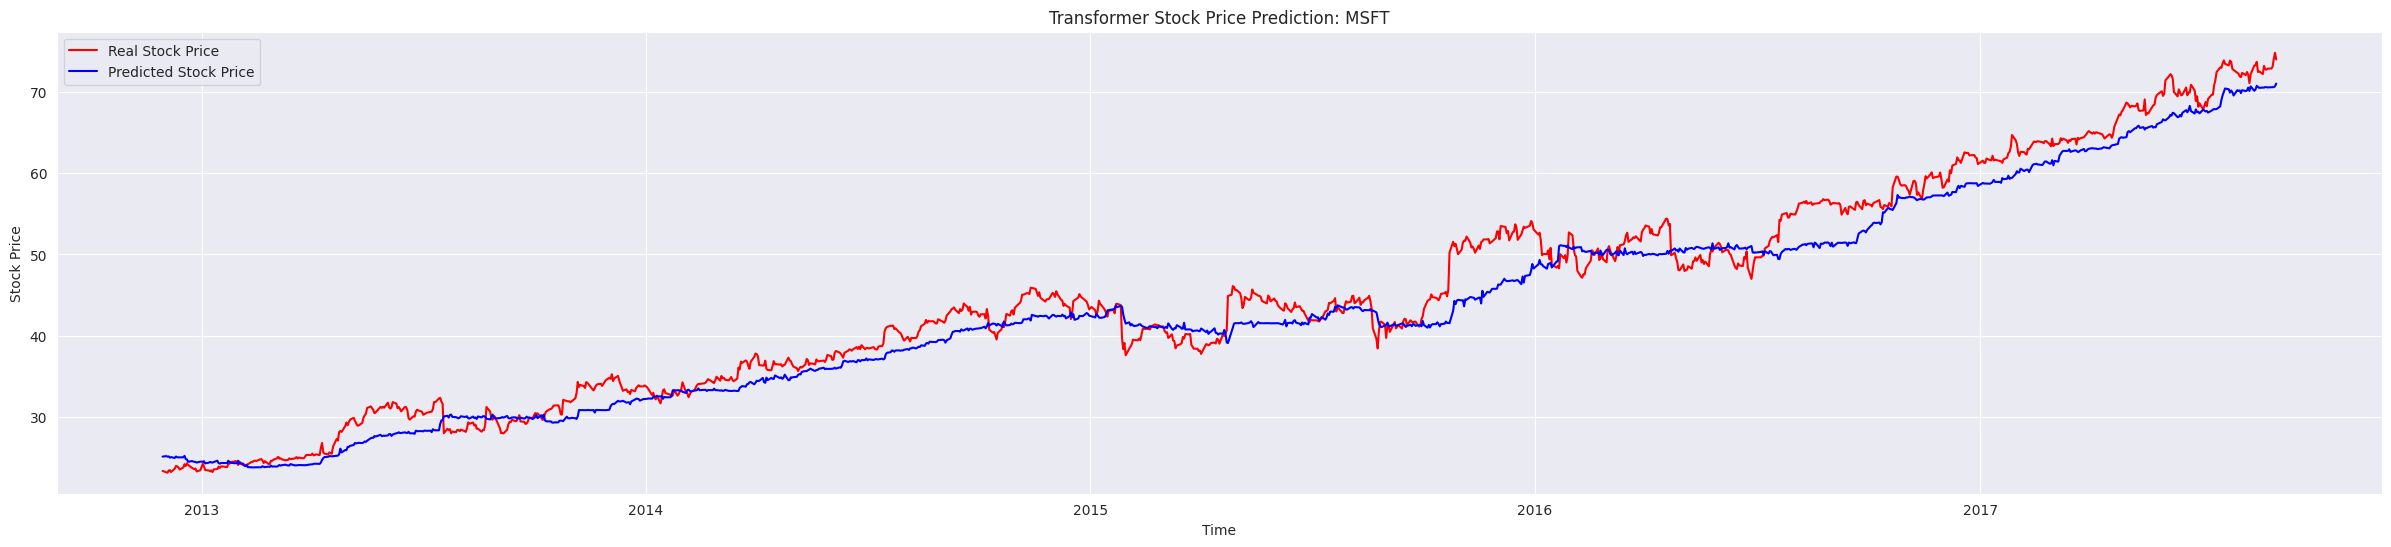

In [13]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 6))
axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df.index, y_tests, color = 'red', label = 'Real Stock Price')
axes.plot(df.index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'Transformer Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
#plt.savefig(f'./plots/transformer_baseline2_pred_{predicted_ticker}.png')
plt.show()

In [14]:
correct_pred = 0
incorrect_pred = 0

count_up = 0
count_down = 0
for i in range(1, len(y_tests)):
    if (y_tests[i] - y_tests[i-1])>0:
      count_up+=1
    else:
      count_down+=1
    if (y_tests[i] - y_tests[i-1]) * (y_test_preds[i] - y_tests[i-1]) > 0:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy of predicting rise/drop: ", correct_pred / (correct_pred + incorrect_pred))

Accuracy of predicting rise/drop:  0.4903926482873851


In [15]:
print(count_up, count_down)

619 578
